## Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Didattica/ML/exam_2024-2025/project_work_segmentazione_off-road")    # Change to the correct directory

## Environment Setup

In [ ]:
import torch
import torch.nn as nn
import albumentations as A
import os
import numpy as np
from PIL import Image
#Installation required on Colab to be able to use the library containing the desired loss function.
!pip install segmentation_models_pytorch
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tqdm import tqdm
from torch import optim
from torch.utils.data import Dataset, random_split, Subset, DataLoader
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import DeepLabV3_MobileNet_V3_Large_Weights
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
import shutil

IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 8
DATA_DIR = './resources/train'                  # Change to the correct directory
MODEL_SAVE_PATH = 'best_segmentation_model.pth' # Change to the correct directory
LOG_DIR = './runs'                              # Change to the correct directory

# Class Mapper
COLOR_TO_ID = {
    (255, 255, 255): 0,   # Background
    (178, 176, 153): 1,   # Smooth Trail
    (128, 255, 0):   2,   # Traversable grass
    (156, 76, 30):   3,   # Rough Trail
    (255, 0, 128):   4,   # Puddle
    (255, 0, 0):     5,   # Obstacle
    (0, 160, 0):     6,   # Non Traversable Low Vegetation
    (40, 80, 0):     7,   # High Vegetation
    (1, 88, 255):    8    # Sky
}

#Script used to delete the previous Tensorboard folder, avoiding graphs overlapping the previous ones.
"""
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
    print("Removed existing TensorBoard log directory.")
"""


'\nif os.path.exists(LOG_DIR):\n    shutil.rmtree(LOG_DIR)\n    print("Removed existing TensorBoard log directory.")\n'

## Dataset class

In [ ]:

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, aug_transformation=None, augmentation=False, num_augmentations=3):
        self.root_dir = root_dir
        self.aug_transformation = aug_transformation
        self.augmentation = augmentation
        self.base_transformation = A.Compose([
            A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.ToTensorV2()
        ], additional_targets={'mask': 'mask'})
        self.num_augmentations = num_augmentations
        self.samples = []
        self.mapper = np.full((256, 256, 256), 0, dtype=np.uint8)  # Default = background (0)
        for rgb, class_id in COLOR_TO_ID.items():
            r, g, b = rgb
            self.mapper[r, g, b] = class_id

        # Loading samples from the provided directory
        for folder_name in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder_name)
            if os.path.isdir(folder_path):
                rgb_path = os.path.join(folder_path, 'rgb.jpg')
                labels_path = os.path.join(folder_path, 'labels.png')
                if os.path.exists(rgb_path) and os.path.exists(labels_path):
                    self.samples.append((rgb_path, labels_path, False))
                    if augmentation:
                        for i in range(num_augmentations):
                            self.samples.append((rgb_path, labels_path, True))
                else:
                    print(f"Warning: Missing rgb.jpg or labels.png in {folder_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rgb_path, labels_path, augmentation = self.samples[idx]

        image = np.array(Image.open(rgb_path).convert("RGB"))
        mask = np.array(Image.open(labels_path).convert("RGB"))
        mask = self.mapper[
            mask[..., 0],
            mask[..., 1],
            mask[..., 2]
        ]

        if augmentation:
            augmented = self.aug_transformation(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            augmented = self.base_transformation(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

## Model Architecture

In [19]:

class SegmentationModel(nn.Module):
    def __init__(self, num_classes=9):
        super(SegmentationModel, self).__init__()

        self.model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1)

        self.model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        return self.model(x)['out']

model_summary = SegmentationModel()
print(model_summary)

SegmentationModel(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv

## Functions used to split the dataset

In [ ]:

# Transformations used to perform augmentation on the training set only.
augmentation_transformation = A.Compose([
    A.OneOf([
        A.RandomResizedCrop(size=(IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=10, p=1.0),
        A.Affine(translate_percent=(0.05, 0.05), scale=(0.95, 1.05), rotate=(-10,10), shear=(-5,5), fit_output=True, p=1.0),
        A.Perspective(scale=(0.05, 0.1), keep_size=True, fit_output=False, p=1.0),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
        A.GaussianBlur(blur_limit=5, sigma_limit=(0.1, 2.0), p=1.0),
    ], p=1.0),
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2(),
], additional_targets={'mask': 'mask'})

# Function to split the dataset into a training set and a validation set.
def create_split(data_dir='./resources/train', train_ratio=0.8):

    num_augmentation = 1
    augmented_dataset = SegmentationDataset(root_dir=data_dir, aug_transformation=augmentation_transformation, augmentation=True, num_augmentations=num_augmentation)
    dataset = SegmentationDataset(root_dir=data_dir, aug_transformation=None, augmentation=False)

    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_indices, val_indices = random_split(range(len(dataset)), [train_size, val_size])
    num_samples_per_image = 1 + num_augmentation

    all_train_indices = []
    for idx in train_indices:
        base = idx * num_samples_per_image
        all_train_indices.extend([base + i for i in range(num_samples_per_image)])

    train_dataset = Subset(augmented_dataset, all_train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, pin_memory=True)

    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=True)

    print(f"Total samples: {len(dataset)}")

    print("Numero di immagini originali nel train set:", len(train_indices))
    print("Numero di immagini trasformate nel train set:", len(train_dataset) - len(train_indices))

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    return train_loader, val_loader

# Function to create k-folds for cross-validation.
def create_split_k_fold(data_dir = './resources/train', num_fold = 3):
    num_augmentation = 1
    num_samples_per_image = 1 + num_augmentation
    augmented_dataset = SegmentationDataset(root_dir=data_dir, aug_transformation=augmentation_transformation, augmentation=True, num_augmentations=num_augmentation)
    dataset = SegmentationDataset(root_dir=data_dir, aug_transformation=None, augmentation=False)
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=1)
    folds = []

    for train_indices, val_indices in kf.split(range(len(dataset))):
        all_train_indices = []
        for idx in train_indices:
            base = idx * num_samples_per_image
            all_train_indices.extend([base + i for i in range(num_samples_per_image)])

        train_dataset = Subset(augmented_dataset, all_train_indices)
        val_dataset = Subset(dataset, val_indices)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=True)

        folds.append((train_loader, val_loader))

    print(f"Number of folds created: {len(folds)}")

    return folds


## Functions to compute the IoU metrics

In [21]:
def compute_iou(mask1, mask2, label):
  intersection = np.sum((mask1 == label) & (mask2 == label))
  union = np.sum((mask1 == label) | (mask2 == label))
  if union == 0:
    return np.nan
  return intersection / union


def compute_all_iou(mask1, mask2, num_labels=8):
  iou_scores = np.zeros(num_labels)
  for label in range(num_labels):
    iou = compute_iou(mask1, mask2, label+1)
    iou_scores[label] = iou
  return iou_scores

## Functions to train the model

In [ ]:

# Definition of the combined loss function.
dice_loss = DiceLoss(mode='multiclass')
focal_loss = FocalLoss(mode='multiclass', gamma=2.0)

def combined_loss(pred, target):
    return 0.3*focal_loss(pred, target) + 0.7*dice_loss(pred, target)

def train_model(train_loader, val_loader, num_epochs=25, lr=1e-3, device='cuda', writer=None):
    model = SegmentationModel().to(device)

    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    loss_function = combined_loss

    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    val_ious = []
    val_accuracies = []
    best_val_iou = 0
    best_model = None
    patience = 10
    no_improvement_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        IOUs = np.zeros(8)
        total_loss = 0

        train_loader = tqdm(train_loader, desc="Training start")
        for i, (imgs, masks) in enumerate(train_loader):
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)
            loss = loss_function(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.detach().item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if writer is not None:
            writer.add_scalar('Train/Loss', avg_train_loss, epoch + 1)

        model.eval()
        total_val_loss = 0
        correct_pixels = 0
        total_pixels = 0
        preds_all, labels_all = [], []
        with torch.no_grad():
            val_loader = tqdm(val_loader, desc="Validation start")
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = loss_function(outputs, masks)
                total_val_loss += loss.detach().item()

                predictions = torch.nn.functional.softmax(outputs, dim=1)
                pred_labels = torch.argmax(predictions, dim=1)
                pred_labels = pred_labels.float()
                correct_pixels += (pred_labels == masks).sum().item()
                total_pixels += masks.numel()

                preds_all.append(pred_labels.cpu())
                labels_all.append(masks.cpu())

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            if writer is not None:
                writer.add_scalar('Val/Loss', avg_val_loss, epoch + 1)

            accuracy = correct_pixels / total_pixels
            val_accuracies.append(accuracy)
            if writer is not None:
                writer.add_scalar('Val/Pixel_Wise_Accuracy', accuracy, epoch + 1)

            preds_all = torch.cat(preds_all)
            labels_all = torch.cat(labels_all)

            masks1 = labels_all.cpu().numpy()
            masks2 = preds_all.cpu().numpy()

            IOUs = compute_all_iou(masks1, masks2)
            mean_iou = np.nanmean(IOUs)

            val_ious.append(mean_iou)

            if writer is not None:
                writer.add_scalar('Val/MeanIoU', mean_iou, epoch + 1)
                for i, iou in enumerate(IOUs):
                    writer.add_scalar(f'IoUs/IoU_Class_{i+1}', iou, epoch + 1)

            print('-'*50)
            print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, Mean IoU: {mean_iou:.4f}")
            np.set_printoptions(precision=3, suppress=True)
            print(f"All IOUs for Epoch {epoch + 1}/{num_epochs}: {IOUs}")
            print('-' * 50)

            if mean_iou > best_val_iou:
                best_val_iou = mean_iou.item()
                best_model = model
                no_improvement_counter = 0
                print("New best model found!")
            else:
                no_improvement_counter += 1
                print(f"No improvement for {no_improvement_counter} epoch(s)")

            if no_improvement_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_accuracies, label='Accuracy')
    plt.title('Pixel-wise Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_ious, label='Mean IoU')
    plt.title('Validation Mean IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_model, best_val_iou

## Function to test the model

In [23]:

ID_TO_COLOR = {v: k for k, v in COLOR_TO_ID.items()}

def id_to_rgb_mask(id_mask_np, id_to_color_map):
    h, w = id_mask_np.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color_rgb in id_to_color_map.items():
        rgb_mask[id_mask_np == class_id] = color_rgb
    return rgb_mask

## TensorBoard Setup

In [35]:
%load_ext tensorboard
notebook.list()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Known TensorBoard instances:
  - port 6007: logdir ./runs (started 3:34:02 ago; pid 17468)
  - port 6006: logdir ./runs (started 1 day, 18:21:21 ago; pid 18384)
  - port 6006: logdir ./runs (started 1 day, 16:09:40 ago; pid 2192)
  - port 6006: logdir ./runs (started 1 day, 19:57:40 ago; pid 9136)


## Choice of the device

In [28]:
device = ""
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using device:", device)
    print(f"Name GPU device: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')  # Fallback to CPU
    print("CUDA not available, CPU is used")

Using device: cuda
Name GPU device: NVIDIA GeForce RTX 4060 Laptop GPU


## Creation of DataLoaders

In [ ]:
#Only if you want to train the model without cross-validation
#train_loader, val_loader = create_split(data_dir=DATA_DIR)

## Model Training

Number of folds created: 5
--------------------------------------------------
Training on fold 1/5
--------------------------------------------------
Training samples: 1488
Validation samples: 187
Epoch 1/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]


--------------------------------------------------
Epoch 1/20 - Train Loss: 0.6113, Val Loss: 0.4383, Accuracy: 0.7613, Mean IoU: 0.4366
All IOUs for Epoch 1/20: [0.465 0.539 0.527 0.    0.005 0.302 0.799 0.856]
--------------------------------------------------
New best model found!
Epoch 2/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]


--------------------------------------------------
Epoch 2/20 - Train Loss: 0.4066, Val Loss: 0.3862, Accuracy: 0.7820, Mean IoU: 0.4799
All IOUs for Epoch 2/20: [0.523 0.567 0.557 0.    0.179 0.335 0.807 0.873]
--------------------------------------------------
New best model found!
Epoch 3/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]


--------------------------------------------------
Epoch 3/20 - Train Loss: 0.3450, Val Loss: 0.3527, Accuracy: 0.8057, Mean IoU: 0.4996
All IOUs for Epoch 3/20: [0.634 0.567 0.58  0.    0.146 0.366 0.825 0.878]
--------------------------------------------------
New best model found!
Epoch 4/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.68it/s]


--------------------------------------------------
Epoch 4/20 - Train Loss: 0.3050, Val Loss: 0.3410, Accuracy: 0.8137, Mean IoU: 0.5039
All IOUs for Epoch 4/20: [0.643 0.571 0.601 0.    0.153 0.347 0.835 0.881]
--------------------------------------------------
New best model found!
Epoch 5/20


Validation start: 100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


--------------------------------------------------
Epoch 5/20 - Train Loss: 0.2775, Val Loss: 0.3437, Accuracy: 0.8145, Mean IoU: 0.5084
All IOUs for Epoch 5/20: [0.636 0.603 0.588 0.    0.157 0.375 0.83  0.879]
--------------------------------------------------
New best model found!
Epoch 6/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.72it/s]


--------------------------------------------------
Epoch 6/20 - Train Loss: 0.2606, Val Loss: 0.3423, Accuracy: 0.8132, Mean IoU: 0.5232
All IOUs for Epoch 6/20: [0.652 0.572 0.605 0.152 0.147 0.349 0.829 0.88 ]
--------------------------------------------------
New best model found!
Epoch 7/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


--------------------------------------------------
Epoch 7/20 - Train Loss: 0.2389, Val Loss: 0.3487, Accuracy: 0.8112, Mean IoU: 0.5223
All IOUs for Epoch 7/20: [0.63  0.589 0.567 0.155 0.164 0.352 0.839 0.882]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 8/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.14it/s]


--------------------------------------------------
Epoch 8/20 - Train Loss: 0.2251, Val Loss: 0.3547, Accuracy: 0.8120, Mean IoU: 0.5263
All IOUs for Epoch 8/20: [0.65  0.571 0.565 0.19  0.174 0.346 0.835 0.879]
--------------------------------------------------
New best model found!
Epoch 9/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.40it/s]


--------------------------------------------------
Epoch 9/20 - Train Loss: 0.2095, Val Loss: 0.3585, Accuracy: 0.8067, Mean IoU: 0.5144
All IOUs for Epoch 9/20: [0.632 0.581 0.551 0.149 0.139 0.346 0.836 0.882]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 10/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.64it/s]


--------------------------------------------------
Epoch 10/20 - Train Loss: 0.1921, Val Loss: 0.3484, Accuracy: 0.8162, Mean IoU: 0.5330
All IOUs for Epoch 10/20: [0.653 0.608 0.568 0.158 0.183 0.38  0.833 0.881]
--------------------------------------------------
New best model found!
Epoch 11/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.94it/s]


--------------------------------------------------
Epoch 11/20 - Train Loss: 0.1826, Val Loss: 0.3540, Accuracy: 0.8164, Mean IoU: 0.5356
All IOUs for Epoch 11/20: [0.647 0.585 0.593 0.213 0.159 0.365 0.839 0.884]
--------------------------------------------------
New best model found!
Epoch 12/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]


--------------------------------------------------
Epoch 12/20 - Train Loss: 0.1835, Val Loss: 0.3537, Accuracy: 0.8119, Mean IoU: 0.5235
All IOUs for Epoch 12/20: [0.631 0.583 0.596 0.141 0.166 0.349 0.838 0.883]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 13/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.78it/s]


--------------------------------------------------
Epoch 13/20 - Train Loss: 0.1734, Val Loss: 0.3764, Accuracy: 0.8069, Mean IoU: 0.5167
All IOUs for Epoch 13/20: [0.577 0.607 0.577 0.152 0.158 0.347 0.836 0.881]
--------------------------------------------------
No improvement for 2 epoch(s)
Epoch 14/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.47it/s]


--------------------------------------------------
Epoch 14/20 - Train Loss: 0.1611, Val Loss: 0.3693, Accuracy: 0.8097, Mean IoU: 0.5228
All IOUs for Epoch 14/20: [0.642 0.581 0.532 0.155 0.201 0.347 0.839 0.886]
--------------------------------------------------
No improvement for 3 epoch(s)
Epoch 15/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


--------------------------------------------------
Epoch 15/20 - Train Loss: 0.1583, Val Loss: 0.3689, Accuracy: 0.8128, Mean IoU: 0.5313
All IOUs for Epoch 15/20: [0.65  0.601 0.538 0.192 0.188 0.358 0.839 0.885]
--------------------------------------------------
No improvement for 4 epoch(s)
Epoch 16/20


Validation start: 100%|██████████| 24/24 [00:04<00:00,  4.81it/s]


--------------------------------------------------
Epoch 16/20 - Train Loss: 0.1511, Val Loss: 0.3860, Accuracy: 0.8089, Mean IoU: 0.5265
All IOUs for Epoch 16/20: [0.642 0.588 0.51  0.176 0.203 0.37  0.838 0.885]
--------------------------------------------------
No improvement for 5 epoch(s)
Epoch 17/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.71it/s]


--------------------------------------------------
Epoch 17/20 - Train Loss: 0.1550, Val Loss: 0.3672, Accuracy: 0.8179, Mean IoU: 0.5309
All IOUs for Epoch 17/20: [0.667 0.593 0.559 0.163 0.183 0.357 0.841 0.884]
--------------------------------------------------
No improvement for 6 epoch(s)
Epoch 18/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.81it/s]


--------------------------------------------------
Epoch 18/20 - Train Loss: 0.1446, Val Loss: 0.3792, Accuracy: 0.8134, Mean IoU: 0.5301
All IOUs for Epoch 18/20: [0.644 0.601 0.572 0.197 0.147 0.362 0.834 0.883]
--------------------------------------------------
No improvement for 7 epoch(s)
Epoch 19/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.82it/s]


--------------------------------------------------
Epoch 19/20 - Train Loss: 0.1435, Val Loss: 0.3824, Accuracy: 0.8148, Mean IoU: 0.5358
All IOUs for Epoch 19/20: [0.632 0.596 0.605 0.242 0.164 0.333 0.831 0.885]
--------------------------------------------------
New best model found!
Epoch 20/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]


--------------------------------------------------
Epoch 20/20 - Train Loss: 0.1421, Val Loss: 0.3670, Accuracy: 0.8138, Mean IoU: 0.5284
All IOUs for Epoch 20/20: [0.621 0.602 0.596 0.218 0.125 0.347 0.835 0.883]
--------------------------------------------------
No improvement for 1 epoch(s)


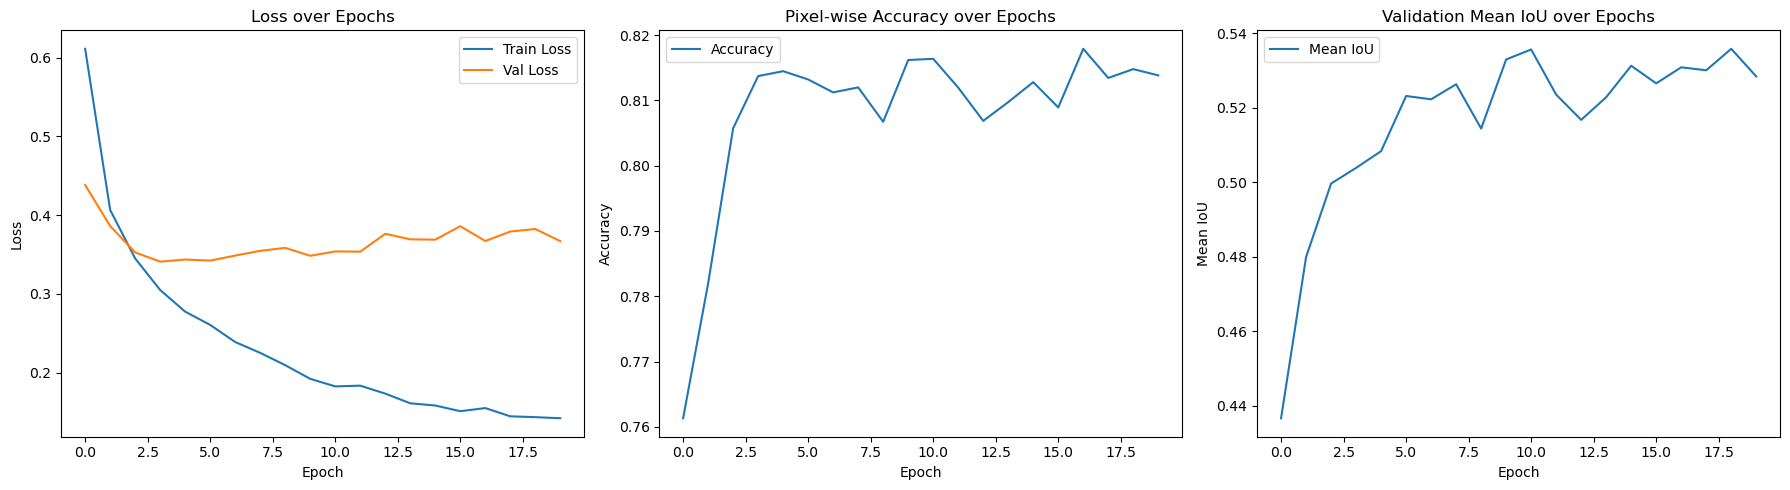

New best model found for fold 1 with mean IoU: 0.5358
--------------------------------------------------
Training on fold 2/5
--------------------------------------------------
Training samples: 1490
Validation samples: 186
Epoch 1/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]


--------------------------------------------------
Epoch 1/20 - Train Loss: 0.5901, Val Loss: 0.3990, Accuracy: 0.8010, Mean IoU: 0.4696
All IOUs for Epoch 1/20: [0.546 0.58  0.611 0.    0.054 0.267 0.827 0.871]
--------------------------------------------------
New best model found!
Epoch 2/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


--------------------------------------------------
Epoch 2/20 - Train Loss: 0.4062, Val Loss: 0.3549, Accuracy: 0.8048, Mean IoU: 0.5228
All IOUs for Epoch 2/20: [0.583 0.583 0.622 0.    0.367 0.32  0.831 0.877]
--------------------------------------------------
New best model found!
Epoch 3/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.69it/s]


--------------------------------------------------
Epoch 3/20 - Train Loss: 0.3464, Val Loss: 0.3492, Accuracy: 0.8110, Mean IoU: 0.5064
All IOUs for Epoch 3/20: [0.57  0.611 0.596 0.    0.272 0.277 0.843 0.882]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 4/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.41it/s]


--------------------------------------------------
Epoch 4/20 - Train Loss: 0.3119, Val Loss: 0.3373, Accuracy: 0.8095, Mean IoU: 0.5241
All IOUs for Epoch 4/20: [0.563 0.596 0.629 0.    0.394 0.294 0.835 0.881]
--------------------------------------------------
New best model found!
Epoch 5/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]


--------------------------------------------------
Epoch 5/20 - Train Loss: 0.2835, Val Loss: 0.3327, Accuracy: 0.8180, Mean IoU: 0.5284
All IOUs for Epoch 5/20: [0.594 0.626 0.609 0.    0.365 0.31  0.841 0.881]
--------------------------------------------------
New best model found!
Epoch 6/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


--------------------------------------------------
Epoch 6/20 - Train Loss: 0.2646, Val Loss: 0.3376, Accuracy: 0.8163, Mean IoU: 0.5399
All IOUs for Epoch 6/20: [0.613 0.607 0.605 0.149 0.295 0.329 0.841 0.88 ]
--------------------------------------------------
New best model found!
Epoch 7/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.76it/s]


--------------------------------------------------
Epoch 7/20 - Train Loss: 0.2453, Val Loss: 0.3249, Accuracy: 0.8234, Mean IoU: 0.5507
All IOUs for Epoch 7/20: [0.626 0.62  0.633 0.107 0.352 0.335 0.846 0.885]
--------------------------------------------------
New best model found!
Epoch 8/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.71it/s]


--------------------------------------------------
Epoch 8/20 - Train Loss: 0.2254, Val Loss: 0.3318, Accuracy: 0.8203, Mean IoU: 0.5622
All IOUs for Epoch 8/20: [0.605 0.625 0.62  0.116 0.472 0.336 0.843 0.881]
--------------------------------------------------
New best model found!
Epoch 9/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.53it/s]


--------------------------------------------------
Epoch 9/20 - Train Loss: 0.2043, Val Loss: 0.3327, Accuracy: 0.8225, Mean IoU: 0.5838
All IOUs for Epoch 9/20: [0.63  0.634 0.629 0.209 0.531 0.311 0.845 0.881]
--------------------------------------------------
New best model found!
Epoch 10/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.53it/s]


--------------------------------------------------
Epoch 10/20 - Train Loss: 0.2004, Val Loss: 0.3269, Accuracy: 0.8174, Mean IoU: 0.5425
All IOUs for Epoch 10/20: [0.552 0.627 0.614 0.133 0.356 0.325 0.852 0.882]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 11/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]


--------------------------------------------------
Epoch 11/20 - Train Loss: 0.1922, Val Loss: 0.3223, Accuracy: 0.8239, Mean IoU: 0.5733
All IOUs for Epoch 11/20: [0.6   0.636 0.627 0.176 0.496 0.319 0.851 0.882]
--------------------------------------------------
No improvement for 2 epoch(s)
Epoch 12/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.38it/s]


--------------------------------------------------
Epoch 12/20 - Train Loss: 0.1756, Val Loss: 0.3326, Accuracy: 0.8222, Mean IoU: 0.5597
All IOUs for Epoch 12/20: [0.59  0.636 0.628 0.098 0.458 0.33  0.852 0.886]
--------------------------------------------------
No improvement for 3 epoch(s)
Epoch 13/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.49it/s]


--------------------------------------------------
Epoch 13/20 - Train Loss: 0.1764, Val Loss: 0.3564, Accuracy: 0.8083, Mean IoU: 0.5330
All IOUs for Epoch 13/20: [0.576 0.629 0.515 0.155 0.332 0.327 0.847 0.882]
--------------------------------------------------
No improvement for 4 epoch(s)
Epoch 14/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.57it/s]


--------------------------------------------------
Epoch 14/20 - Train Loss: 0.1740, Val Loss: 0.3312, Accuracy: 0.8213, Mean IoU: 0.5463
All IOUs for Epoch 14/20: [0.605 0.624 0.63  0.137 0.328 0.321 0.849 0.876]
--------------------------------------------------
No improvement for 5 epoch(s)
Epoch 15/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]


--------------------------------------------------
Epoch 15/20 - Train Loss: 0.1604, Val Loss: 0.3456, Accuracy: 0.8224, Mean IoU: 0.5535
All IOUs for Epoch 15/20: [0.605 0.641 0.616 0.133 0.39  0.313 0.85  0.88 ]
--------------------------------------------------
No improvement for 6 epoch(s)
Epoch 16/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]


--------------------------------------------------
Epoch 16/20 - Train Loss: 0.1519, Val Loss: 0.3397, Accuracy: 0.8271, Mean IoU: 0.5635
All IOUs for Epoch 16/20: [0.604 0.634 0.639 0.14  0.42  0.326 0.855 0.889]
--------------------------------------------------
No improvement for 7 epoch(s)
Epoch 17/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


--------------------------------------------------
Epoch 17/20 - Train Loss: 0.1488, Val Loss: 0.3463, Accuracy: 0.8184, Mean IoU: 0.5601
All IOUs for Epoch 17/20: [0.585 0.631 0.583 0.217 0.422 0.307 0.851 0.885]
--------------------------------------------------
No improvement for 8 epoch(s)
Epoch 18/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]


--------------------------------------------------
Epoch 18/20 - Train Loss: 0.1522, Val Loss: 0.3605, Accuracy: 0.8098, Mean IoU: 0.5603
All IOUs for Epoch 18/20: [0.523 0.639 0.553 0.139 0.591 0.307 0.851 0.879]
--------------------------------------------------
No improvement for 9 epoch(s)
Epoch 19/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]


--------------------------------------------------
Epoch 19/20 - Train Loss: 0.1478, Val Loss: 0.3629, Accuracy: 0.8142, Mean IoU: 0.5506
All IOUs for Epoch 19/20: [0.577 0.631 0.57  0.159 0.433 0.307 0.843 0.885]
--------------------------------------------------
No improvement for 10 epoch(s)
Early stopping triggered after 19 epochs.


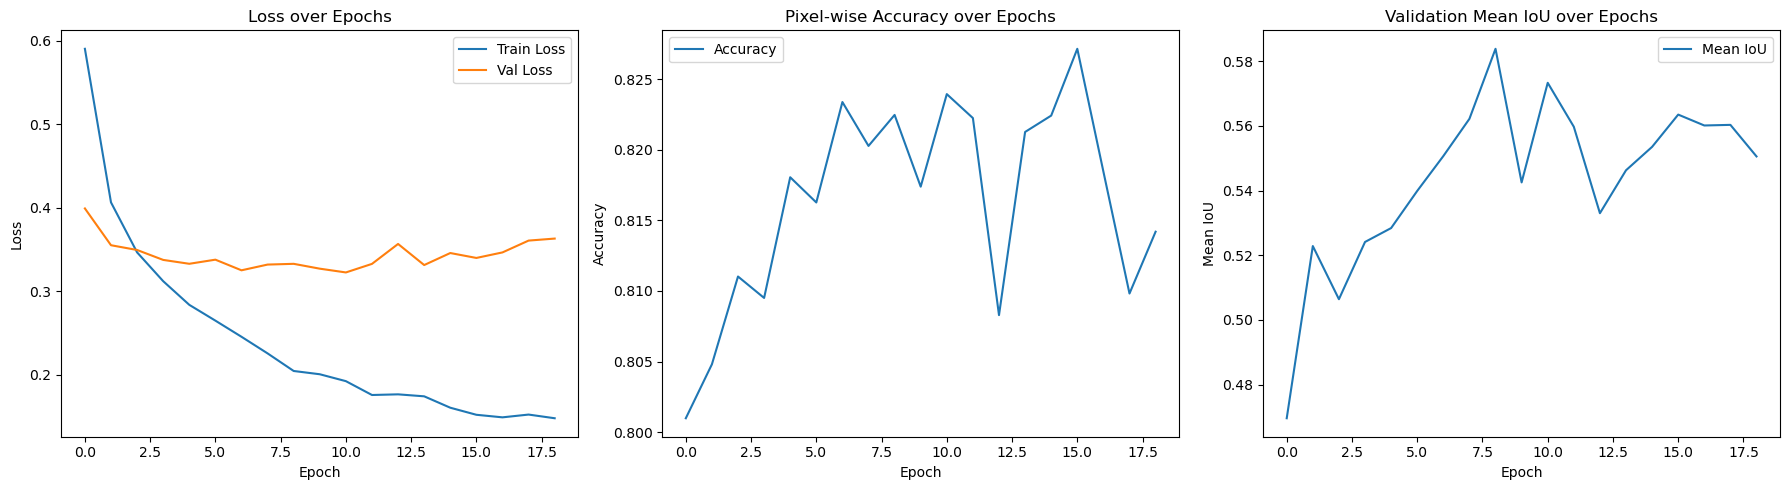

New best model found for fold 2 with mean IoU: 0.5838
--------------------------------------------------
Training on fold 3/5
--------------------------------------------------
Training samples: 1490
Validation samples: 186
Epoch 1/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.41it/s]


--------------------------------------------------
Epoch 1/20 - Train Loss: 0.6145, Val Loss: 0.4730, Accuracy: 0.7434, Mean IoU: 0.4199
All IOUs for Epoch 1/20: [0.355 0.565 0.491 0.    0.019 0.26  0.811 0.857]
--------------------------------------------------
New best model found!
Epoch 2/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.68it/s]


--------------------------------------------------
Epoch 2/20 - Train Loss: 0.4109, Val Loss: 0.3988, Accuracy: 0.7987, Mean IoU: 0.4956
All IOUs for Epoch 2/20: [0.601 0.59  0.571 0.    0.199 0.312 0.831 0.86 ]
--------------------------------------------------
New best model found!
Epoch 3/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.45it/s]


--------------------------------------------------
Epoch 3/20 - Train Loss: 0.3494, Val Loss: 0.3852, Accuracy: 0.8027, Mean IoU: 0.5345
All IOUs for Epoch 3/20: [0.61  0.608 0.556 0.    0.445 0.357 0.835 0.865]
--------------------------------------------------
New best model found!
Epoch 4/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.58it/s]


--------------------------------------------------
Epoch 4/20 - Train Loss: 0.3172, Val Loss: 0.3865, Accuracy: 0.8147, Mean IoU: 0.5468
All IOUs for Epoch 4/20: [0.652 0.632 0.566 0.    0.513 0.311 0.833 0.868]
--------------------------------------------------
New best model found!
Epoch 5/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]


--------------------------------------------------
Epoch 5/20 - Train Loss: 0.2844, Val Loss: 0.3670, Accuracy: 0.8167, Mean IoU: 0.5526
All IOUs for Epoch 5/20: [0.648 0.628 0.581 0.    0.52  0.337 0.84  0.866]
--------------------------------------------------
New best model found!
Epoch 6/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.17it/s]


--------------------------------------------------
Epoch 6/20 - Train Loss: 0.2585, Val Loss: 0.3887, Accuracy: 0.8150, Mean IoU: 0.5629
All IOUs for Epoch 6/20: [0.665 0.624 0.559 0.089 0.561 0.291 0.84  0.874]
--------------------------------------------------
New best model found!
Epoch 7/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]


--------------------------------------------------
Epoch 7/20 - Train Loss: 0.2357, Val Loss: 0.3641, Accuracy: 0.8190, Mean IoU: 0.5904
All IOUs for Epoch 7/20: [0.661 0.627 0.57  0.22  0.549 0.391 0.839 0.865]
--------------------------------------------------
New best model found!
Epoch 8/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.83it/s]


--------------------------------------------------
Epoch 8/20 - Train Loss: 0.2223, Val Loss: 0.3691, Accuracy: 0.8090, Mean IoU: 0.5695
All IOUs for Epoch 8/20: [0.621 0.621 0.549 0.207 0.483 0.363 0.835 0.876]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 9/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.80it/s]


--------------------------------------------------
Epoch 9/20 - Train Loss: 0.2092, Val Loss: 0.3801, Accuracy: 0.8204, Mean IoU: 0.5574
All IOUs for Epoch 9/20: [0.654 0.647 0.589 0.088 0.422 0.344 0.843 0.872]
--------------------------------------------------
No improvement for 2 epoch(s)
Epoch 10/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]


--------------------------------------------------
Epoch 10/20 - Train Loss: 0.1935, Val Loss: 0.3896, Accuracy: 0.8143, Mean IoU: 0.5518
All IOUs for Epoch 10/20: [0.658 0.623 0.564 0.066 0.517 0.276 0.836 0.874]
--------------------------------------------------
No improvement for 3 epoch(s)
Epoch 11/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s]


--------------------------------------------------
Epoch 11/20 - Train Loss: 0.1835, Val Loss: 0.3789, Accuracy: 0.8154, Mean IoU: 0.5873
All IOUs for Epoch 11/20: [0.652 0.653 0.544 0.254 0.563 0.327 0.834 0.872]
--------------------------------------------------
No improvement for 4 epoch(s)
Epoch 12/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.90it/s]


--------------------------------------------------
Epoch 12/20 - Train Loss: 0.1765, Val Loss: 0.3780, Accuracy: 0.8210, Mean IoU: 0.5841
All IOUs for Epoch 12/20: [0.655 0.653 0.578 0.163 0.575 0.341 0.837 0.869]
--------------------------------------------------
No improvement for 5 epoch(s)
Epoch 13/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.85it/s]


--------------------------------------------------
Epoch 13/20 - Train Loss: 0.1709, Val Loss: 0.3791, Accuracy: 0.8205, Mean IoU: 0.5806
All IOUs for Epoch 13/20: [0.663 0.649 0.548 0.148 0.543 0.379 0.845 0.871]
--------------------------------------------------
No improvement for 6 epoch(s)
Epoch 14/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]


--------------------------------------------------
Epoch 14/20 - Train Loss: 0.1693, Val Loss: 0.3736, Accuracy: 0.8205, Mean IoU: 0.5707
All IOUs for Epoch 14/20: [0.67  0.622 0.603 0.136 0.455 0.363 0.838 0.879]
--------------------------------------------------
No improvement for 7 epoch(s)
Epoch 15/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]


--------------------------------------------------
Epoch 15/20 - Train Loss: 0.1584, Val Loss: 0.3912, Accuracy: 0.8117, Mean IoU: 0.5629
All IOUs for Epoch 15/20: [0.629 0.63  0.53  0.136 0.503 0.359 0.847 0.87 ]
--------------------------------------------------
No improvement for 8 epoch(s)
Epoch 16/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]


--------------------------------------------------
Epoch 16/20 - Train Loss: 0.1586, Val Loss: 0.3757, Accuracy: 0.8248, Mean IoU: 0.5880
All IOUs for Epoch 16/20: [0.671 0.639 0.581 0.164 0.549 0.382 0.842 0.876]
--------------------------------------------------
No improvement for 9 epoch(s)
Epoch 17/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]


--------------------------------------------------
Epoch 17/20 - Train Loss: 0.1516, Val Loss: 0.3868, Accuracy: 0.8211, Mean IoU: 0.5771
All IOUs for Epoch 17/20: [0.665 0.658 0.553 0.115 0.572 0.342 0.84  0.873]
--------------------------------------------------
No improvement for 10 epoch(s)
Early stopping triggered after 17 epochs.


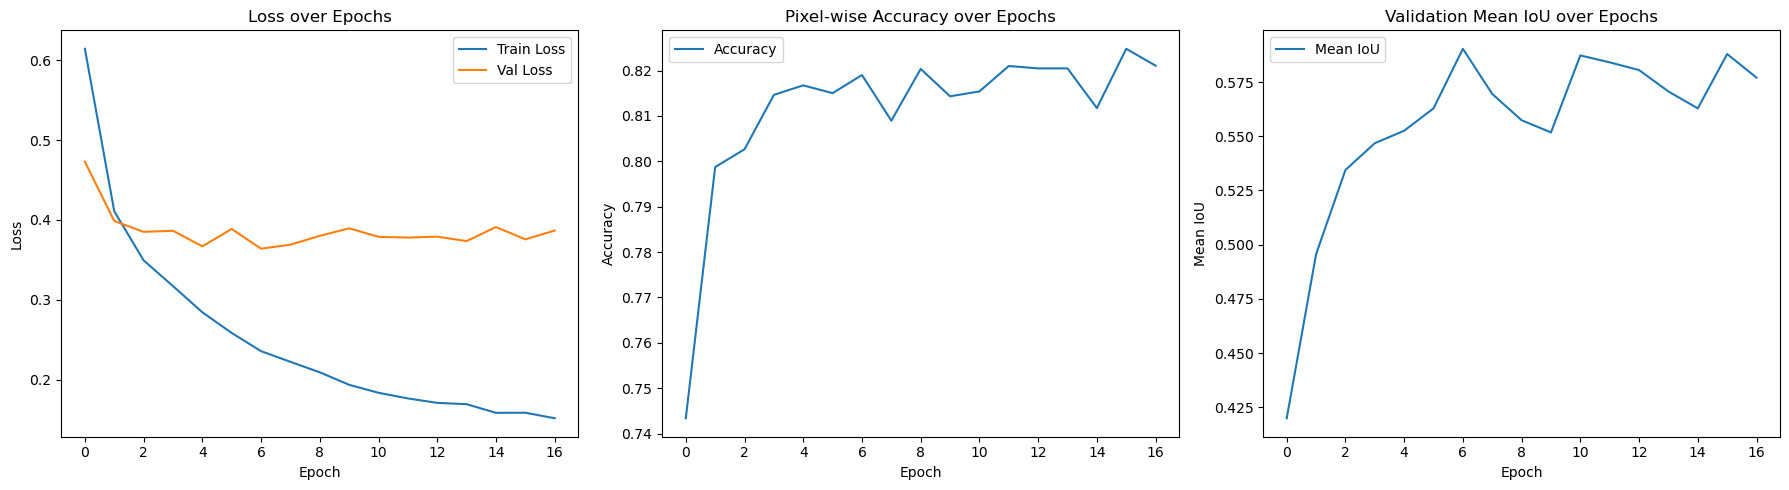

New best model found for fold 3 with mean IoU: 0.5904
--------------------------------------------------
Training on fold 4/5
--------------------------------------------------
Training samples: 1490
Validation samples: 186
Epoch 1/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.94it/s]


--------------------------------------------------
Epoch 1/20 - Train Loss: 0.5847, Val Loss: 0.4256, Accuracy: 0.7700, Mean IoU: 0.4497
All IOUs for Epoch 1/20: [0.551 0.563 0.532 0.    0.017 0.269 0.801 0.863]
--------------------------------------------------
New best model found!
Epoch 2/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.90it/s]


--------------------------------------------------
Epoch 2/20 - Train Loss: 0.3996, Val Loss: 0.3808, Accuracy: 0.7884, Mean IoU: 0.4960
All IOUs for Epoch 2/20: [0.582 0.578 0.558 0.    0.249 0.308 0.817 0.876]
--------------------------------------------------
New best model found!
Epoch 3/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s]


--------------------------------------------------
Epoch 3/20 - Train Loss: 0.3457, Val Loss: 0.3652, Accuracy: 0.7866, Mean IoU: 0.5046
All IOUs for Epoch 3/20: [0.553 0.585 0.567 0.    0.303 0.333 0.817 0.879]
--------------------------------------------------
New best model found!
Epoch 4/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.92it/s]


--------------------------------------------------
Epoch 4/20 - Train Loss: 0.3069, Val Loss: 0.3700, Accuracy: 0.7952, Mean IoU: 0.5091
All IOUs for Epoch 4/20: [0.571 0.588 0.574 0.    0.29  0.35  0.819 0.88 ]
--------------------------------------------------
New best model found!
Epoch 5/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]


--------------------------------------------------
Epoch 5/20 - Train Loss: 0.2846, Val Loss: 0.3536, Accuracy: 0.8021, Mean IoU: 0.5136
All IOUs for Epoch 5/20: [0.615 0.599 0.59  0.007 0.255 0.348 0.816 0.879]
--------------------------------------------------
New best model found!
Epoch 6/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.11it/s]


--------------------------------------------------
Epoch 6/20 - Train Loss: 0.2501, Val Loss: 0.3689, Accuracy: 0.7937, Mean IoU: 0.5070
All IOUs for Epoch 6/20: [0.562 0.6   0.568 0.019 0.28  0.326 0.82  0.882]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 7/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.91it/s]


--------------------------------------------------
Epoch 7/20 - Train Loss: 0.2320, Val Loss: 0.3660, Accuracy: 0.8021, Mean IoU: 0.5211
All IOUs for Epoch 7/20: [0.608 0.612 0.58  0.064 0.299 0.3   0.824 0.882]
--------------------------------------------------
New best model found!
Epoch 8/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]


--------------------------------------------------
Epoch 8/20 - Train Loss: 0.2203, Val Loss: 0.3819, Accuracy: 0.7993, Mean IoU: 0.5194
All IOUs for Epoch 8/20: [0.634 0.598 0.562 0.062 0.28  0.319 0.816 0.885]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 9/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.09it/s]


--------------------------------------------------
Epoch 9/20 - Train Loss: 0.2029, Val Loss: 0.4020, Accuracy: 0.7823, Mean IoU: 0.5065
All IOUs for Epoch 9/20: [0.504 0.6   0.554 0.111 0.259 0.323 0.82  0.881]
--------------------------------------------------
No improvement for 2 epoch(s)
Epoch 10/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]


--------------------------------------------------
Epoch 10/20 - Train Loss: 0.1926, Val Loss: 0.3817, Accuracy: 0.7992, Mean IoU: 0.5369
All IOUs for Epoch 10/20: [0.571 0.615 0.586 0.18  0.287 0.351 0.82  0.885]
--------------------------------------------------
New best model found!
Epoch 11/20


Validation start: 100%|██████████| 24/24 [00:05<00:00,  4.00it/s]


--------------------------------------------------
Epoch 11/20 - Train Loss: 0.1798, Val Loss: 0.3768, Accuracy: 0.8081, Mean IoU: 0.5424
All IOUs for Epoch 11/20: [0.651 0.612 0.575 0.162 0.288 0.345 0.82  0.886]
--------------------------------------------------
New best model found!
Epoch 12/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.76it/s]


--------------------------------------------------
Epoch 12/20 - Train Loss: 0.1717, Val Loss: 0.3825, Accuracy: 0.8032, Mean IoU: 0.5303
All IOUs for Epoch 12/20: [0.643 0.607 0.586 0.132 0.265 0.307 0.818 0.884]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 13/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.91it/s]


--------------------------------------------------
Epoch 13/20 - Train Loss: 0.1719, Val Loss: 0.3748, Accuracy: 0.8124, Mean IoU: 0.5465
All IOUs for Epoch 13/20: [0.653 0.626 0.588 0.161 0.305 0.323 0.828 0.888]
--------------------------------------------------
New best model found!
Epoch 14/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s]


--------------------------------------------------
Epoch 14/20 - Train Loss: 0.1555, Val Loss: 0.3770, Accuracy: 0.8114, Mean IoU: 0.5455
All IOUs for Epoch 14/20: [0.649 0.629 0.594 0.174 0.288 0.316 0.827 0.888]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 15/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s]


--------------------------------------------------
Epoch 15/20 - Train Loss: 0.1539, Val Loss: 0.3850, Accuracy: 0.8046, Mean IoU: 0.5400
All IOUs for Epoch 15/20: [0.612 0.615 0.578 0.187 0.276 0.341 0.825 0.886]
--------------------------------------------------
No improvement for 2 epoch(s)
Epoch 16/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.93it/s]


--------------------------------------------------
Epoch 16/20 - Train Loss: 0.1477, Val Loss: 0.4022, Accuracy: 0.8034, Mean IoU: 0.5365
All IOUs for Epoch 16/20: [0.617 0.61  0.584 0.19  0.29  0.286 0.827 0.888]
--------------------------------------------------
No improvement for 3 epoch(s)
Epoch 17/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s]


--------------------------------------------------
Epoch 17/20 - Train Loss: 0.1452, Val Loss: 0.4022, Accuracy: 0.8099, Mean IoU: 0.5351
All IOUs for Epoch 17/20: [0.646 0.61  0.604 0.125 0.253 0.33  0.823 0.89 ]
--------------------------------------------------
No improvement for 4 epoch(s)
Epoch 18/20


Validation start: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


--------------------------------------------------
Epoch 18/20 - Train Loss: 0.1465, Val Loss: 0.4031, Accuracy: 0.8042, Mean IoU: 0.5355
All IOUs for Epoch 18/20: [0.587 0.616 0.588 0.169 0.296 0.312 0.826 0.889]
--------------------------------------------------
No improvement for 5 epoch(s)
Epoch 19/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.77it/s]


--------------------------------------------------
Epoch 19/20 - Train Loss: 0.1407, Val Loss: 0.3946, Accuracy: 0.8097, Mean IoU: 0.5383
All IOUs for Epoch 19/20: [0.644 0.623 0.575 0.14  0.276 0.33  0.829 0.889]
--------------------------------------------------
No improvement for 6 epoch(s)
Epoch 20/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s]


--------------------------------------------------
Epoch 20/20 - Train Loss: 0.1389, Val Loss: 0.3981, Accuracy: 0.8079, Mean IoU: 0.5417
All IOUs for Epoch 20/20: [0.646 0.609 0.582 0.161 0.302 0.322 0.824 0.887]
--------------------------------------------------
No improvement for 7 epoch(s)


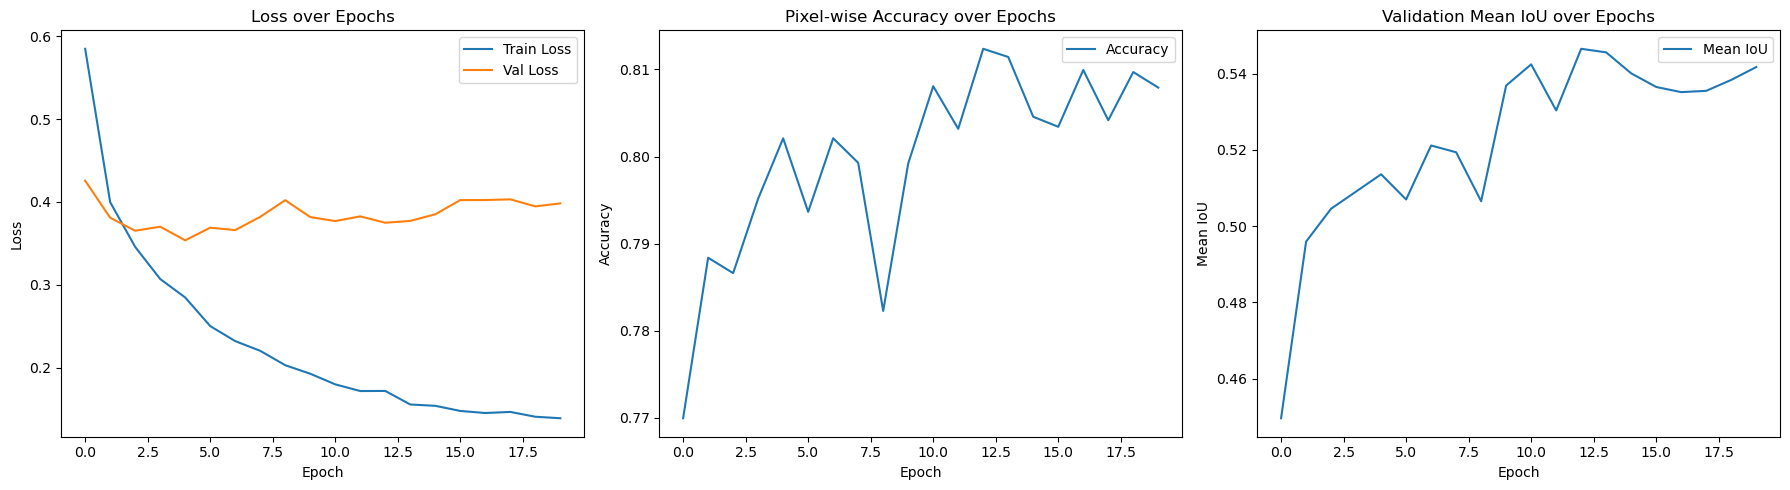

No improvement for fold 4, mean IoU: 0.5465
--------------------------------------------------
Training on fold 5/5
--------------------------------------------------
Training samples: 1490
Validation samples: 186
Epoch 1/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]


--------------------------------------------------
Epoch 1/20 - Train Loss: 0.5983, Val Loss: 0.4492, Accuracy: 0.7683, Mean IoU: 0.4603
All IOUs for Epoch 1/20: [0.55  0.501 0.564 0.    0.112 0.317 0.792 0.847]
--------------------------------------------------
New best model found!
Epoch 2/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s]


--------------------------------------------------
Epoch 2/20 - Train Loss: 0.4030, Val Loss: 0.4033, Accuracy: 0.7765, Mean IoU: 0.4864
All IOUs for Epoch 2/20: [0.601 0.476 0.55  0.    0.288 0.318 0.797 0.86 ]
--------------------------------------------------
New best model found!
Epoch 3/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.63it/s]


--------------------------------------------------
Epoch 3/20 - Train Loss: 0.3445, Val Loss: 0.3929, Accuracy: 0.7841, Mean IoU: 0.4982
All IOUs for Epoch 3/20: [0.598 0.556 0.543 0.    0.288 0.338 0.801 0.862]
--------------------------------------------------
New best model found!
Epoch 4/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.78it/s]


--------------------------------------------------
Epoch 4/20 - Train Loss: 0.3109, Val Loss: 0.4016, Accuracy: 0.7766, Mean IoU: 0.4837
All IOUs for Epoch 4/20: [0.592 0.524 0.5   0.    0.305 0.291 0.792 0.865]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 5/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.65it/s]


--------------------------------------------------
Epoch 5/20 - Train Loss: 0.2742, Val Loss: 0.4061, Accuracy: 0.7726, Mean IoU: 0.4833
All IOUs for Epoch 5/20: [0.594 0.505 0.556 0.    0.293 0.259 0.795 0.863]
--------------------------------------------------
No improvement for 2 epoch(s)
Epoch 6/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.81it/s]


--------------------------------------------------
Epoch 6/20 - Train Loss: 0.2557, Val Loss: 0.4125, Accuracy: 0.7729, Mean IoU: 0.4736
All IOUs for Epoch 6/20: [0.568 0.519 0.538 0.018 0.258 0.218 0.802 0.867]
--------------------------------------------------
No improvement for 3 epoch(s)
Epoch 7/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]


--------------------------------------------------
Epoch 7/20 - Train Loss: 0.2347, Val Loss: 0.4130, Accuracy: 0.7707, Mean IoU: 0.4910
All IOUs for Epoch 7/20: [0.555 0.514 0.548 0.163 0.205 0.268 0.8   0.875]
--------------------------------------------------
No improvement for 4 epoch(s)
Epoch 8/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s]


--------------------------------------------------
Epoch 8/20 - Train Loss: 0.2211, Val Loss: 0.4203, Accuracy: 0.7713, Mean IoU: 0.4956
All IOUs for Epoch 8/20: [0.565 0.503 0.546 0.236 0.173 0.266 0.806 0.869]
--------------------------------------------------
No improvement for 5 epoch(s)
Epoch 9/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.85it/s]


--------------------------------------------------
Epoch 9/20 - Train Loss: 0.2063, Val Loss: 0.4154, Accuracy: 0.7818, Mean IoU: 0.5132
All IOUs for Epoch 9/20: [0.593 0.537 0.574 0.271 0.213 0.257 0.797 0.864]
--------------------------------------------------
New best model found!
Epoch 10/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.82it/s]


--------------------------------------------------
Epoch 10/20 - Train Loss: 0.1940, Val Loss: 0.4416, Accuracy: 0.7723, Mean IoU: 0.5069
All IOUs for Epoch 10/20: [0.542 0.502 0.553 0.308 0.243 0.233 0.801 0.874]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 11/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s]


--------------------------------------------------
Epoch 11/20 - Train Loss: 0.1864, Val Loss: 0.4216, Accuracy: 0.7828, Mean IoU: 0.5127
All IOUs for Epoch 11/20: [0.563 0.535 0.567 0.284 0.24  0.228 0.812 0.874]
--------------------------------------------------
No improvement for 2 epoch(s)
Epoch 12/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


--------------------------------------------------
Epoch 12/20 - Train Loss: 0.1780, Val Loss: 0.4272, Accuracy: 0.7831, Mean IoU: 0.5168
All IOUs for Epoch 12/20: [0.589 0.538 0.556 0.313 0.221 0.233 0.807 0.877]
--------------------------------------------------
New best model found!
Epoch 13/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s]


--------------------------------------------------
Epoch 13/20 - Train Loss: 0.1740, Val Loss: 0.4327, Accuracy: 0.7813, Mean IoU: 0.5237
All IOUs for Epoch 13/20: [0.557 0.531 0.583 0.328 0.245 0.264 0.805 0.877]
--------------------------------------------------
New best model found!
Epoch 14/20


Validation start: 100%|██████████| 24/24 [00:08<00:00,  2.80it/s]


--------------------------------------------------
Epoch 14/20 - Train Loss: 0.1580, Val Loss: 0.4275, Accuracy: 0.7766, Mean IoU: 0.5212
All IOUs for Epoch 14/20: [0.572 0.535 0.521 0.335 0.258 0.266 0.804 0.877]
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch 15/20


Validation start: 100%|██████████| 24/24 [00:08<00:00,  2.79it/s]


--------------------------------------------------
Epoch 15/20 - Train Loss: 0.1628, Val Loss: 0.4264, Accuracy: 0.7818, Mean IoU: 0.5171
All IOUs for Epoch 15/20: [0.579 0.533 0.54  0.307 0.231 0.261 0.81  0.876]
--------------------------------------------------
No improvement for 2 epoch(s)
Epoch 16/20


Validation start: 100%|██████████| 24/24 [00:07<00:00,  3.33it/s]


--------------------------------------------------
Epoch 16/20 - Train Loss: 0.1520, Val Loss: 0.4360, Accuracy: 0.7801, Mean IoU: 0.5210
All IOUs for Epoch 16/20: [0.566 0.522 0.55  0.323 0.249 0.27  0.811 0.879]
--------------------------------------------------
No improvement for 3 epoch(s)
Epoch 17/20


Validation start: 100%|██████████| 24/24 [00:07<00:00,  3.06it/s]


--------------------------------------------------
Epoch 17/20 - Train Loss: 0.1488, Val Loss: 0.4425, Accuracy: 0.7811, Mean IoU: 0.5232
All IOUs for Epoch 17/20: [0.572 0.536 0.549 0.319 0.241 0.28  0.811 0.877]
--------------------------------------------------
No improvement for 4 epoch(s)
Epoch 18/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


--------------------------------------------------
Epoch 18/20 - Train Loss: 0.1449, Val Loss: 0.4455, Accuracy: 0.7794, Mean IoU: 0.5231
All IOUs for Epoch 18/20: [0.569 0.528 0.55  0.314 0.246 0.29  0.81  0.877]
--------------------------------------------------
No improvement for 5 epoch(s)
Epoch 19/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


--------------------------------------------------
Epoch 19/20 - Train Loss: 0.1436, Val Loss: 0.4680, Accuracy: 0.7697, Mean IoU: 0.5032
All IOUs for Epoch 19/20: [0.572 0.518 0.503 0.291 0.257 0.204 0.802 0.879]
--------------------------------------------------
No improvement for 6 epoch(s)
Epoch 20/20


Validation start: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


--------------------------------------------------
Epoch 20/20 - Train Loss: 0.1483, Val Loss: 0.4523, Accuracy: 0.7790, Mean IoU: 0.5161
All IOUs for Epoch 20/20: [0.564 0.53  0.549 0.288 0.263 0.245 0.809 0.881]
--------------------------------------------------
No improvement for 7 epoch(s)


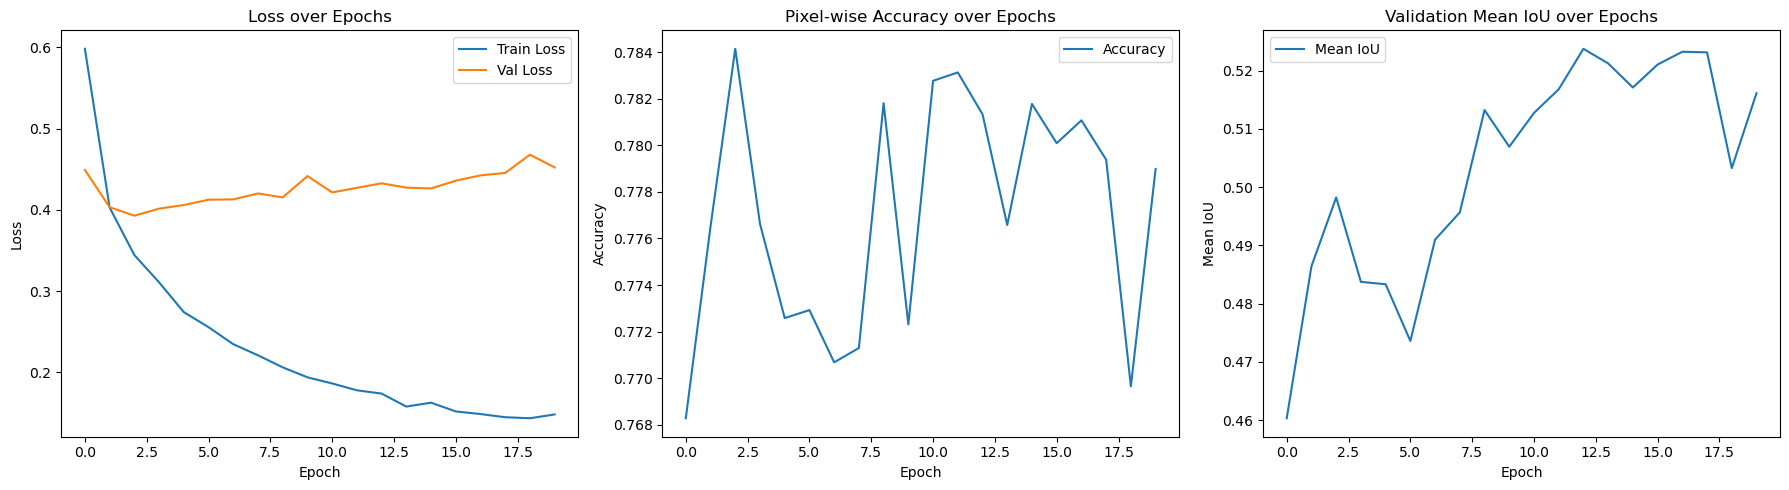

No improvement for fold 5, mean IoU: 0.5237
Training complete!


In [30]:
epochs = 20
learning_rate = 1e-4
n_folds = 5
folds = create_split_k_fold(data_dir=DATA_DIR, num_fold=n_folds)

best_model = None
best_val_iou = 0
best_fold = 0

for fold, (train_loader, val_loader) in enumerate(folds):
    print('-' * 50)
    print(f"Training on fold {fold + 1}/{n_folds}")
    print('-' * 50)
    experiment_name = 'Fold_{}'.format(fold + 1)
    writer = SummaryWriter(os.path.join("runs", experiment_name))
    model, val_iou = train_model(train_loader, val_loader, epochs, learning_rate, device= device, writer=writer)

    if val_iou > best_val_iou:
        best_fold = fold + 1
        best_val_iou = val_iou
        best_model = model
        print(f"New best model found for fold {fold + 1} with mean IoU: {val_iou:.4f}")
    else:
        print(f"No improvement for fold {fold + 1}, mean IoU: {val_iou:.4f}")

print("Training complete!")

## TensorBoard Visualization

In [ ]:
%tensorboard --logdir ./runs --port 6006

## Model Saving

In [33]:
torch.save(best_model.state_dict(), MODEL_SAVE_PATH)

print("Best Model saved to " + MODEL_SAVE_PATH + " with mean IoU: " + "{:.2f}".format(best_val_iou) + " on fold " + str(best_fold))

Best Model saved to best_segmentation_model.pth with mean IoU: 0.59 on fold 3
